In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#### Defining the problem (classical form)

$$\text{Minimize } Z = x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8$$

$\text{Subject to}$

$x_1 + x_2 \geq 1$

$x_2 + x_3 \geq 1$

$x_4 + x_5 \geq 1$

$x_7 + x_8 \geq 1$

$x_6 + x_7 \geq 1$

$x_2 + x_6 \geq 1$

$x_1 + x_6 \geq 1$

$x_4 + x_7 \geq 1$

$x_2 + x_4 \geq 1$

$x_5 + x_8 \geq 1$

$x_3 + x_5 \geq 1$

#### Transforming the problem to QUBO

This is a equivalent form of the problem, passing the constraints as penalty terms(P) in the objective function to be minimized

$$
\min_{x \in \{0,1\}^n} \mu^T x + P
$$

Where P is defined as:

$$
P = \alpha \sum_{(i,j)}[1 - x_i - x_j + x_{i}x_j] + \beta \sum_{(i,j)}x_{i}x_j
$$

Here, $\alpha$ is the wheight of the penalty for violating the constraints, and $\beta$ is the weight of the penalty for over-satisfying the constraints

which is equivalent to

$$
\min_{x \in \{0,1\}^n} \sum_{i}x_i + \alpha \sum_{(i,j)}[1 - x_i - x_j + x_{i}x_j] + \beta \sum_{(i,j)}x_{i}x_j
$$

In [17]:
def declare_problem(a):
    # Initialize Quadratic Program
    mod = QuadraticProgram("maximum coverage problem")

    # Define binary variables
    for i in range(8):
        mod.binary_var(name="x" + str(i + 1))

    # Define the linear term for the objective
    lin = np.ones(8)
    quad = np.zeros((8, 8))

    # Add the original objective: Minimize the sum of x_i
    mod.minimize(constant=0, linear=lin, quadratic=quad)

    # Adjust penalty weights
    alpha = a  # High penalty for violations (x_i + x_j < 1)

    penalties = [
        ("x1", "x2"),
        ("x2", "x3"),
        ("x4", "x5"),
        ("x7", "x8"),
        ("x6", "x7"),
        ("x2", "x6"),
        ("x1", "x6"),
        ("x4", "x7"),
        ("x2", "x4"),
        ("x5", "x8"),
        ("x3", "x5"),
    ]

    for var1, var2 in penalties:
        # Penalty for under-satisfaction: alpha * (1 - x_i - x_j)^2
        mod.objective.constant += alpha  # Constant term (from 1)
        mod.objective.linear[var1] += -alpha  # Linear term for x_i
        mod.objective.linear[var2] += -alpha  # Linear term for x_j
        mod.objective.quadratic[var1, var2] += alpha  # Quadratic term for x_i * x_j

    return mod

In [18]:
def declare_qubo_problem(classic_problem, penalty):
    penalty_value = penalty
    qubo_problem = QuadraticProgramToQubo(penalty=penalty_value).convert(classic_problem)
    return qubo_problem

In [19]:
def hamiltonian_offset(qubo_problem):
    # Returns the hamiltonian and the offset
    return qubo_problem.to_ising()

In [20]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [21]:
c_problem = declare_problem(1000)
print(c_problem.prettyprint())

q_problem = declare_qubo_problem(c_problem, 1)
print(q_problem.prettyprint())

hamiltonian, offset = hamiltonian_offset(q_problem)

Problem name: maximum coverage problem

Minimize
  1000*x1*x2 + 1000*x1*x6 + 1000*x2*x3 + 1000*x2*x4 + 1000*x2*x6 + 1000*x3*x5
  + 1000*x4*x5 + 1000*x4*x7 + 1000*x5*x8 + 1000*x6*x7 + 1000*x7*x8 - 1999*x1
  - 3999*x2 - 1999*x3 - 2999*x4 - 2999*x5 - 2999*x6 - 2999*x7 - 1999*x8 + 11000

Subject to
  No constraints

  Binary variables (8)
    x1 x2 x3 x4 x5 x6 x7 x8

Problem name: maximum coverage problem

Minimize
  1000*x1*x2 + 1000*x1*x6 + 1000*x2*x3 + 1000*x2*x4 + 1000*x2*x6 + 1000*x3*x5
  + 1000*x4*x5 + 1000*x4*x7 + 1000*x5*x8 + 1000*x6*x7 + 1000*x7*x8 - 1999*x1
  - 3999*x2 - 1999*x3 - 2999*x4 - 2999*x5 - 2999*x6 - 2999*x7 - 1999*x8 + 11000

Subject to
  No constraints

  Binary variables (8)
    x1 x2 x3 x4 x5 x6 x7 x8



In [22]:
def run_experiment(n_range, p, shots_estimator, shots_sampler, level):
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=level)

    ansatz = QAOAAnsatz(hamiltonian, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    
    results_x = []
    for i in range(n_range):
        x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")
    results_x_mean = np.mean(results_x, axis=0)

    qc = ansatz.assign_parameters(results_x_mean)
    qc.measure_all()
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa]).result()
    samp_dist = result[0].data.meas.get_counts()

    # Sort the states by their probabilities
    sorted_samp_dist = sorted(samp_dist.items(), key=lambda item: item[1], reverse=True)

    # Extract the top 20 most probable states
    top_20_states = sorted_samp_dist[:20]

    # Calculate probabilities
    total_samples = sum(samp_dist.values())
    top_states = [state for state, _ in top_20_states]
    top_probabilities = [count / total_samples for _, count in top_20_states]

    # Plot a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(top_states, top_probabilities, color="skyblue")
    plt.xlabel("Quantum States")
    plt.ylabel("Probability")
    plt.title("Top 20 Most Probable States")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [23]:
values = {'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 0}
q_problem.objective.evaluate([values[f'x{i}'] for i in range(1, 9)])

4.0

#### Using Performance Measures from Benchmarking the performance of portfolio optimization with QAOA

In [24]:
bestValues = {'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 0}
worstValuesFeasible = {'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 1, 'x6': 1, 'x7': 1, 'x8': 1}
worstValues = {'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 0, 'x6': 0, 'x7': 0, 'x8': 0}

minf = q_problem.objective.evaluate([bestValues[f'x{i}'] for i in range(1, 9)])
maxf = q_problem.objective.evaluate([worstValuesFeasible[f'x{i}'] for i in range(1, 9)])
maxf2 = q_problem.objective.evaluate([worstValues[f'x{i}'] for i in range(1, 9)])
 
minf, maxf, maxf2

(4.0, 8.0, 11000.0)

In [25]:
def r(z, problem):
    return (problem.objective.evaluate(z) - maxf) / (minf - maxf)

In [26]:
r([bestValues[f'x{i}'] for i in range(1, 9)], q_problem), r([worstValuesFeasible[f'x{i}'] for i in range(1, 9)], q_problem), r([worstValues[f'x{i}'] for i in range(1, 9)], q_problem)

(1.0, -0.0, -2748.0)

In [27]:
def run_experiment_performance_measurement(n_range, p, shots_estimator, shots_sampler, level, h, qubo_problem):
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=level)

    ansatz = QAOAAnsatz(h, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = h.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    
    results_x = []
    for i in range(n_range):
        x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")
        results_x.append(res.x)
    results_x_mean = np.mean(results_x, axis=0)

    qc = ansatz.assign_parameters(results_x_mean)
    qc.measure_all()
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa]).result()
    variables = [list(map(int, key)) for key in result[0].data.meas.get_counts().keys()]

    approx_ratios = [r(z, qubo_problem) for z in variables]
    mean_approx_ratio = np.mean(approx_ratios)
    std_dev_approx_ratio = np.std(approx_ratios)
    percent_between_0_and_1 = (sum(0 <= ratio <= 1 for ratio in approx_ratios) / len(approx_ratios)) * 100

    approx_ratios_pos = [r(z, qubo_problem) for z in variables if r(z, qubo_problem) >= 0]
    mean_approx_ratio_pos = np.mean(approx_ratios_pos)
    std_dev_approx_ratio_pos = np.std(approx_ratios_pos)
    
    return mean_approx_ratio, std_dev_approx_ratio, percent_between_0_and_1, mean_approx_ratio_pos, std_dev_approx_ratio_pos

In [25]:
p_values = list(range(1, 15))
r_means = []
r_stds = []
r_percentages = []
r_means_pos = []
r_stds_pos = []

for p in p_values:
    mean_r, std_r, percent_r, r_mean_pos, r_std_pos = run_experiment_performance_measurement(50, p, 1000, 1000, 3, hamiltonian, q_problem)
    r_means.append(mean_r)
    r_stds.append(std_r)
    r_percentages.append(percent_r)
    r_means_pos.append(r_mean_pos)
    r_stds_pos.append(r_std_pos)

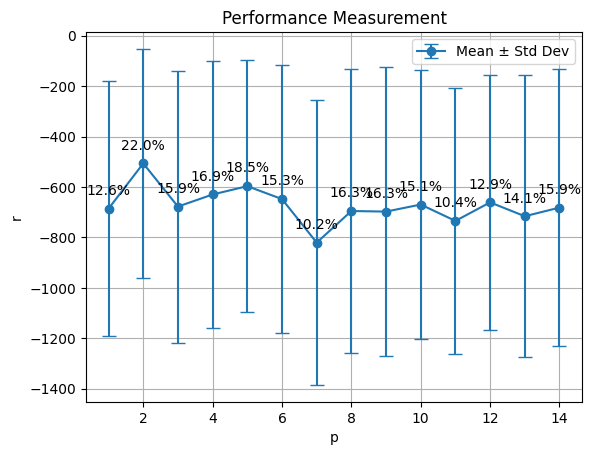

In [22]:
# p_values = list(range(1, 8))
# r_values = []

# for p in p_values:
#     y = run_experiment_performance_measurement(50, p, 1000, 1000, 3)
#     r_values.append(y)

# plt.plot(p_values, r_values, marker='o', linestyle='-')
# plt.xlabel("p")
# plt.ylabel("r")
# plt.title("Performance Measurement")
# plt.grid(True)
# plt.show()

plt.errorbar(p_values, r_means, yerr=r_stds, fmt='o', linestyle='-', capsize=5, label="Mean ± Std Dev")

for i, txt in enumerate(r_percentages):
    plt.annotate(f"{txt:.1f}%", (p_values[i], r_means[i] - r_stds[i] - 0.02),
                 textcoords="data", ha='center', fontsize=10, color='red')

plt.xlabel("p")
plt.ylabel("r")
plt.title("Performance Measurement")
plt.grid(True)
plt.legend()
plt.show()


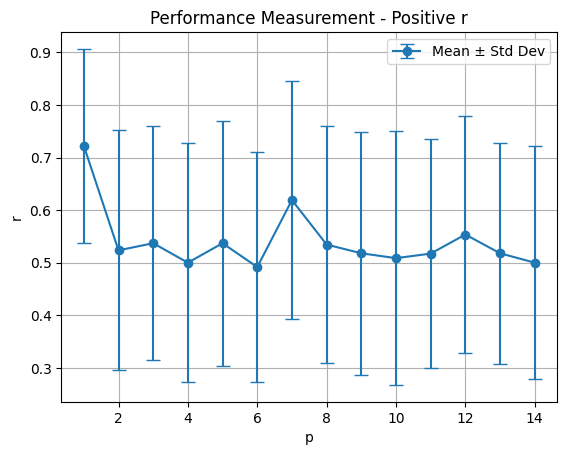

In [30]:
plt.errorbar(p_values, r_means_pos, yerr=r_stds_pos, fmt='o', linestyle='-', capsize=5, label="Mean ± Std Dev")

plt.xlabel("p")
plt.ylabel("r")
plt.title("Performance Measurement - Positive r")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
def run_experiment_performance_measurement_alpha(alpha, n_range, p, shots_estimator, shots_sampler, level):
    c_problem = declare_problem(alpha)

    q_problem = declare_qubo_problem(c_problem, 1)

    hamiltonian, offset = hamiltonian_offset(q_problem)

    return run_experiment_performance_measurement(n_range, p, shots_estimator, shots_sampler, level, hamiltonian, q_problem)

In [17]:
alpha_values = list([1, 10, 100, 1000, 10000, 100000, 1000000])

r_means_alpha = []
r_stds_alpha = []

for alpha in alpha_values:
    mean_r, std_r, percent_r, mean_r_pos, std_r_pos = run_experiment_performance_measurement_alpha(alpha, 50, 3, 1000, 1000, 3)
    r_means_alpha.append(mean_r_pos)
    r_stds_alpha.append(std_r_pos)

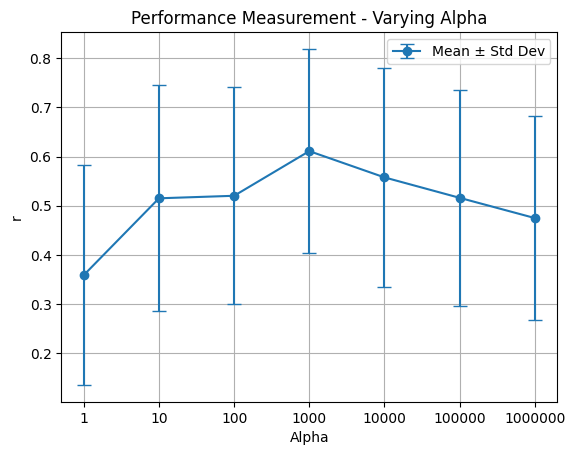

In [20]:
plt.errorbar(range(len(alpha_values)), r_means_alpha, yerr=r_stds_alpha, fmt='o', linestyle='-', capsize=5, label="Mean ± Std Dev")

plt.xticks(range(len(alpha_values)), alpha_values)
plt.xlabel("Alpha")
plt.ylabel("r")
plt.title("Performance Measurement - Varying Alpha")
plt.grid(True)
plt.legend()
plt.show()

##### Unbalanced Penalization

In [147]:
# Initialize Quadratic Program
mod = QuadraticProgram("maximum coverage problem")

# Define binary variables
for i in range(8):
    mod.binary_var(name="x" + str(i + 1))

# Define the linear term for the objective
lin = np.ones(8)
quad = np.zeros((8, 8))

# Add the original objective: Minimize the sum of x_i
mod.minimize(constant=0, linear=lin, quadratic=quad)

l0, l1, l2 = 

penalties = [
    ("x1", "x2"),
    ("x2", "x3"),
    ("x4", "x5"),
    ("x7", "x8"),
    ("x6", "x7"),
    ("x2", "x6"),
    ("x1", "x6"),
    ("x4", "x7"),
    ("x2", "x4"),
    ("x5", "x8"),
    ("x3", "x5"),
]

for var1, var2 in penalties:
    # Penalty for under-satisfaction: alpha * (1 - x_i - x_j)^2
    mod.objective.constant += alpha  # Constant term (from 1)
    mod.objective.linear[var1] += -alpha  # Linear term for x_i
    mod.objective.linear[var2] += -alpha  # Linear term for x_j
    mod.objective.quadratic[var1, var2] += alpha  # Quadratic term for x_i * x_j

# Display the problem
print(mod.prettyprint())

Problem name: maximum coverage problem

Minimize
  x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8

Subject to
  No constraints

  Binary variables (8)
    x1 x2 x3 x4 x5 x6 x7 x8

